In [1]:
import json
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from astropy.table import Table
matplotlib.rcParams['figure.figsize'] = (12, 10)
from tqdm.notebook import tqdm
import json
import sympy

with open('../config.json') as f:
    d = json.load(f)

# import sys
# import os
# folder_a_path = os.path.abspath(os.path.join(os.getcwd(), d["gaiamock_path"]))
# if folder_a_path not in sys.path:
#     sys.path.append(folder_a_path)

# import gaiamock

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Cube setup function

Benjamin Pennell

--

Max Planck Institut für Astronomie, Heidelberg

---

The idea here is to set up all data and parameters into a single `.json` file, which will be passed as a parameter into the script `ComputeCube.py`. 
This is done for several reasons:
- speed: command-line python script is better than a notebook
- organisation: all relevant information for a particular cube can be kept in one place

The philosohy for the cubes is as follows: cubes are to be created for a particular dataset to eliminate assumptions and for the sake of computation
- sky positions and proper motions sampled from catalogue so they don't need to be assumed
- parallax binning obviously chosen for relevant parallaxes, same with apparent magnitudes
- lambda range and sampling style depending on the problem

The name of the game is responsible memory usage. There are big catalogues, and memory allocations can contribute to order-of-magnitude slower computations

## The scripts

We want to compute the grid as quickly as possible, and also stream data to be saved as things go to save on memory and to be able to resume uncompleted computations. To do this, here's the plan

We will compute the cube column-by-column. This makes the most sense since each column is roughly the same computing time as the other (which isn't the same for the rows), and the columns will be the larger axis. We will have a runner script `CreateCube.py` which will split the data into sequence and call `ComputeColumn.py` which launches jobs to parallelise the computing of that column. Here's the pseudocode for `CreateCube.py`

```python
    load config file

    split data into columns
    for each column:
        compute the column in ComputeColumn.py
        append to output data, update log
```

The main time sink is the needless orbit solutions. We can solve this in a couple ways. Here's my ideas:
- broad period cut ($P\!\in\!(1,4)$)
- first compute a coarse cube, and then prevent checking for orbit solutions where none are found
- if 250 marginalisations are done, do 100, and if no orbit solutions are found, then don't try any more.

For now, I'll implement the first and the last

## marginalisation catalogue

In [32]:
main_table = Table.read('../BHPopulation/data/200pc_mdwarfs.fits', format='fits')

In [33]:
percentiles = [20,50,90]
PARALLAX_CUTS = np.array(np.percentile(main_table["parallax"], percentiles))

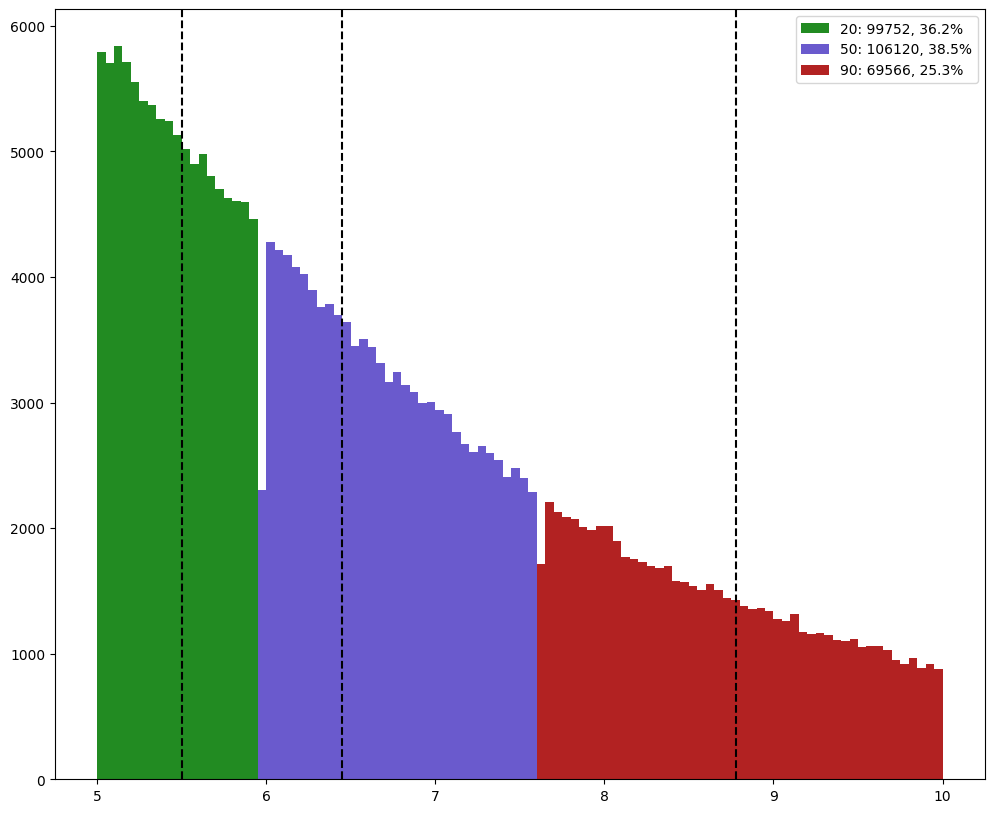

In [34]:
tbins = plt.hist(main_table["parallax"], bins=100, alpha=0);
cols = ["forestgreen", "slateblue", "firebrick"]
for i in range(3):
    plx0 = main_table[[np.argmin(abs(plx-PARALLAX_CUTS)) == i for plx in main_table["parallax"]]]["parallax"]
    plt.hist(plx0, bins=tbins[1], color=cols[i], label="{}: {}, {:.1f}%".format(percentiles[i], len(plx0), len(plx0)/len(main_table)*100))

for p in percentiles:
    plt.axvline(x=np.percentile(main_table["parallax"], p), c="k", linestyle="--");
plt.legend();

In [35]:
memory_reduced = []
relevant_list = ["ra", "dec", "pmra", "pmdec", "parallax", "phot_g_mean_mag"]
for row in tqdm(main_table[::10]): # we don't need every object, really 
    df = dict()
    for item in relevant_list:
        df[item] = float(row[item])
    memory_reduced.append(df)

  0%|          | 0/27544 [00:00<?, ?it/s]

## grid setup

In [36]:
NAME = "200pc_mdwarf_circular_3plx"
PERIOD_RESOLUTION = 125
LAMBDA_RESOLUTION = 50
SAMPLE_COUNT = 250
TRIAL_COUNT = 50
PERIOD_LIMITS = (1,8)
CHOICE_M = float(np.median(main_table["mass_single"]))
Q_TRIM = [0,1]
LAMBDA_INDEX = 4
LAMBDA_NOTE = "sampled by power law of index {}".format(LAMBDA_INDEX)
NOTE = "Cube created from three parallaxes for circular orbits, with a fairly fine resolution and 250 samples. Should be good for inference?"

In [37]:
def calculate_orbit_parameter(m, q, w):
    return q*w*m**(1/3)*(1 + q)**(-2/3)

def q_from_l(l, m, w):
    z = m*(w/l)**3
    q = sympy.symbols("q", real=True)
    roots = sympy.solve(z*q**3 - q**2 - 2*q - 1)
    if len(roots) == 0:
        return -1
    return roots[0]

In [38]:
lambda_sets = []
q_sets = []
reduced_catalogues = []
reference_magnitudes = []

for i, plx in enumerate(PARALLAX_CUTS):
    # take the relevant objects
    temp_cset = []
    for row in memory_reduced:
        if np.argmin(abs(row["parallax"]-PARALLAX_CUTS)) == i:
            temp_cset.append(row)
    reduced_catalogues.append(temp_cset)
    
    # compute the lambda and q sets
    periods = 10**np.linspace(*PERIOD_LIMITS, PERIOD_RESOLUTION)
    min_lambda = calculate_orbit_parameter(np.min(main_table["mass_single"]), 0.05, plx)
    max_lambda = calculate_orbit_parameter(np.max(main_table["mass_single"]), 0.5, plx)
    lambda_limits = np.array([min_lambda,max_lambda])

    lambdas = np.linspace(*(lambda_limits)**(1/LAMBDA_INDEX), LAMBDA_RESOLUTION)**(LAMBDA_INDEX)
    qs = [q_from_l(l, CHOICE_M, plx) for l in lambdas]
    lambda_sets.append(lambdas)
    q_sets.append(qs)

In [39]:
config_file = dict()
config_file["name"] = NAME
config_file["memory_reduced_catalogue"] = reduced_catalogues
config_file["periods"] = periods
config_file["lambdas"] = lambda_sets
config_file["qs"] = q_sets
config_file["shape"] = (PERIOD_RESOLUTION, LAMBDA_RESOLUTION, SAMPLE_COUNT)
config_file["trial_count"] = TRIAL_COUNT
config_file["reference_mass"] = CHOICE_M
config_file["parallaxes"] = PARALLAX_CUTS
config_file["q_boundary"] = Q_TRIM
config_file["lambda_sampling"] = LAMBDA_NOTE
outfile = open("./data/{}.pkl".format(NAME), "wb")
pickle.dump(config_file, outfile)
outfile.close()

# Showing what the output data looks like

In [20]:
imported_cube = pickle.load(open("./data/test_200pc.pkl", "rb"))

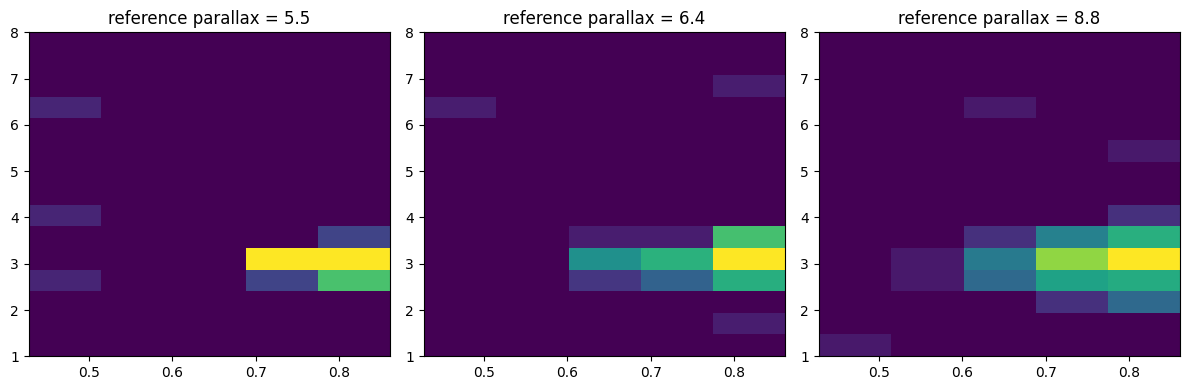

In [21]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharex=True)

logps = np.log10(imported_cube["meta"]["periods"])
yrange = (logps[-1], logps[0])

plxs = list(imported_cube["cube"].keys())

for i in range(3):
    lams = imported_cube["meta"]["qs"][i]
    xrange = np.array((lams[0], lams[-1]))**(1/4)
    extent = [*xrange, *yrange]
    extent = [float(e) for e in extent]
    axs[i].imshow(np.mean(imported_cube["cube"][plxs[i]], axis=2), extent=extent, aspect="auto")
    axs[i].set_title("reference parallax = {:.1f}".format(plxs[i]))
    axs[i].invert_yaxis()

plt.tight_layout()

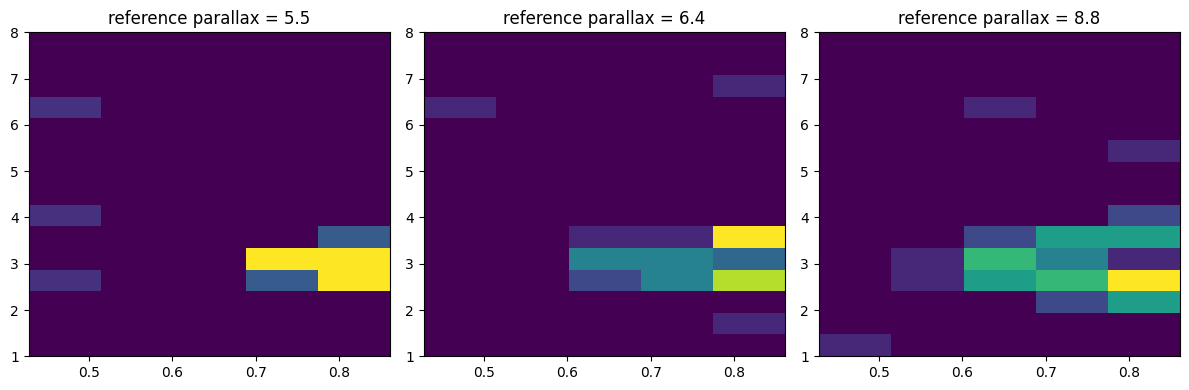

In [30]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharex=True)

logps = np.log10(imported_cube["meta"]["periods"])
yrange = (logps[-1], logps[0])

plxs = list(imported_cube["cube"].keys())

for i in range(3):
    lams = imported_cube["meta"]["qs"][i]
    xrange = np.array((lams[0], lams[-1]))**(1/4)
    extent = [*xrange, *yrange]
    extent = [float(e) for e in extent]
    axs[i].imshow(imported_cube["data"][plxs[i]][:,:,1], extent=extent, aspect="auto")
    axs[i].set_title("reference parallax = {:.1f}".format(plxs[i]))
    axs[i].invert_yaxis()

plt.tight_layout()

## "TRIAL" SCHEME

size: 25x10x25
compare no dropout to 10 dropout

no dropout: 7:54

10 dropout: 5.36

took 70% of the time

"trial orbit solutions" save time yippee

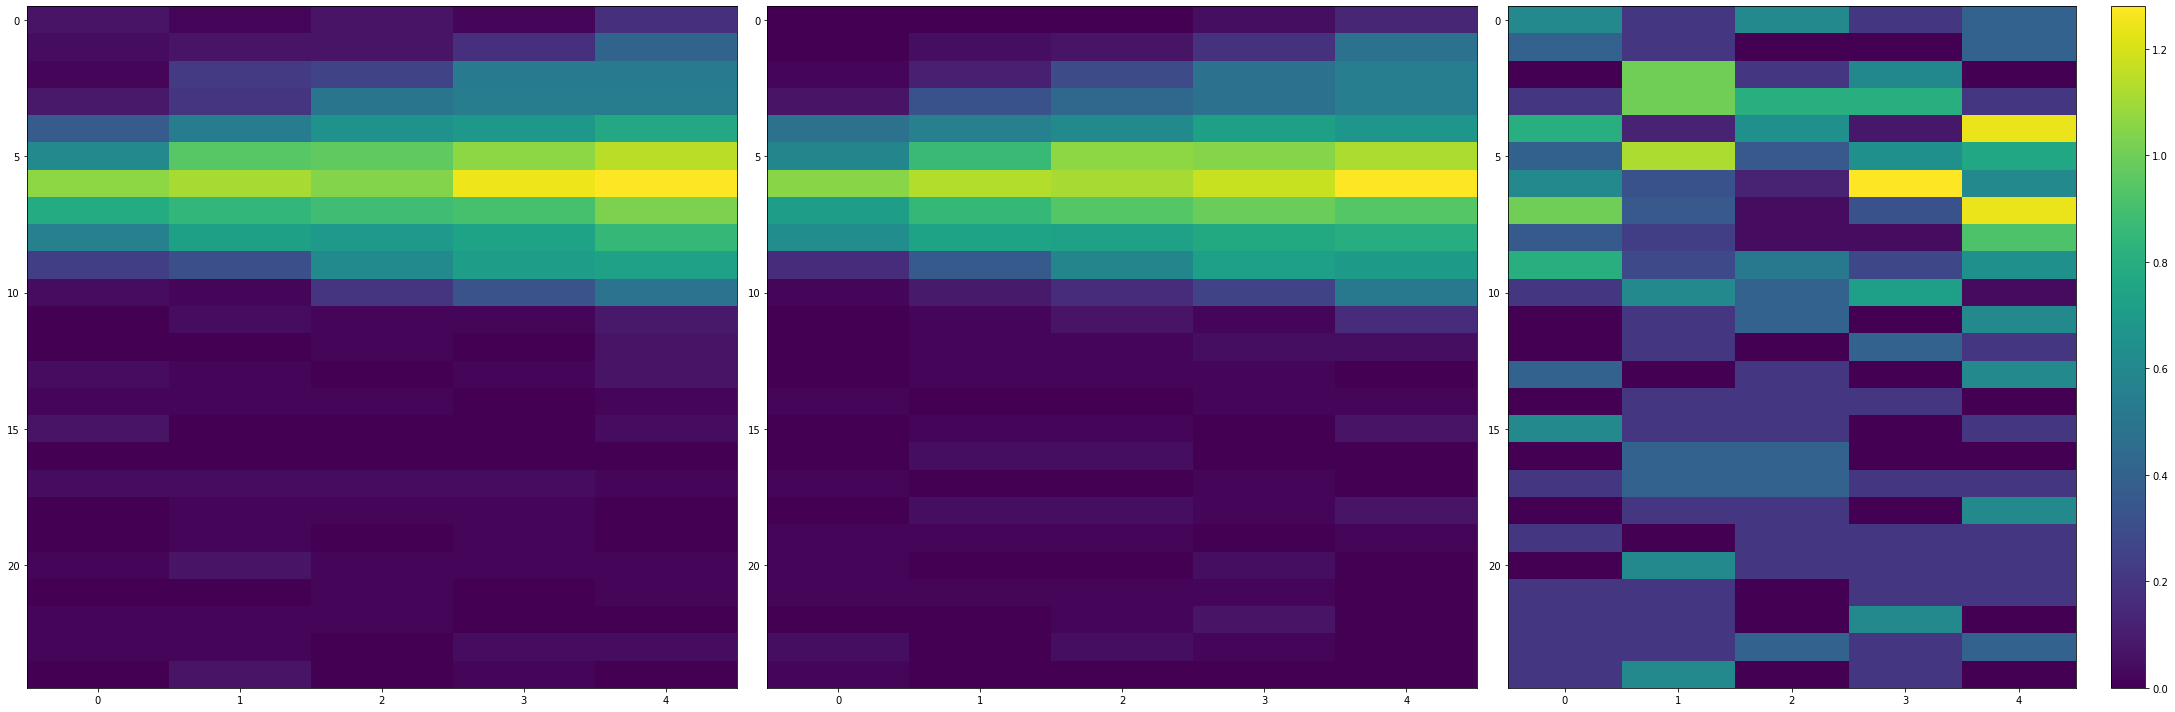

In [38]:
fig, axs = plt.subplots(1,3,figsize=(31,10))
imported_cube_l = pickle.load(open("./data/cube_test_l.pkl", "rb"))
image_l = np.mean(imported_cube_l["cube"], axis=2)
imported_cube_h = pickle.load(open("./data/cube_test_h.pkl", "rb"))
image_h = np.mean(imported_cube_h["cube"], axis=2)

axs[0].imshow(image_l, aspect="auto")
axs[1].imshow(image_h, aspect="auto")
cb = axs[2].imshow(abs(image_l-image_h), aspect="auto")
plt.colorbar(cb)
plt.tight_layout()

## test

In [2]:
imported_cube_circular = pickle.load(open("../data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
imported_cube_thermal = pickle.load(open("../data/2025-12-12-200pc_mdwarf_thermal_3plx.pkl", "rb"))
imported_cube_turnover = pickle.load(open("../data/2025-12-12-200pc_mdwarf_turnover_3plx.pkl", "rb"))

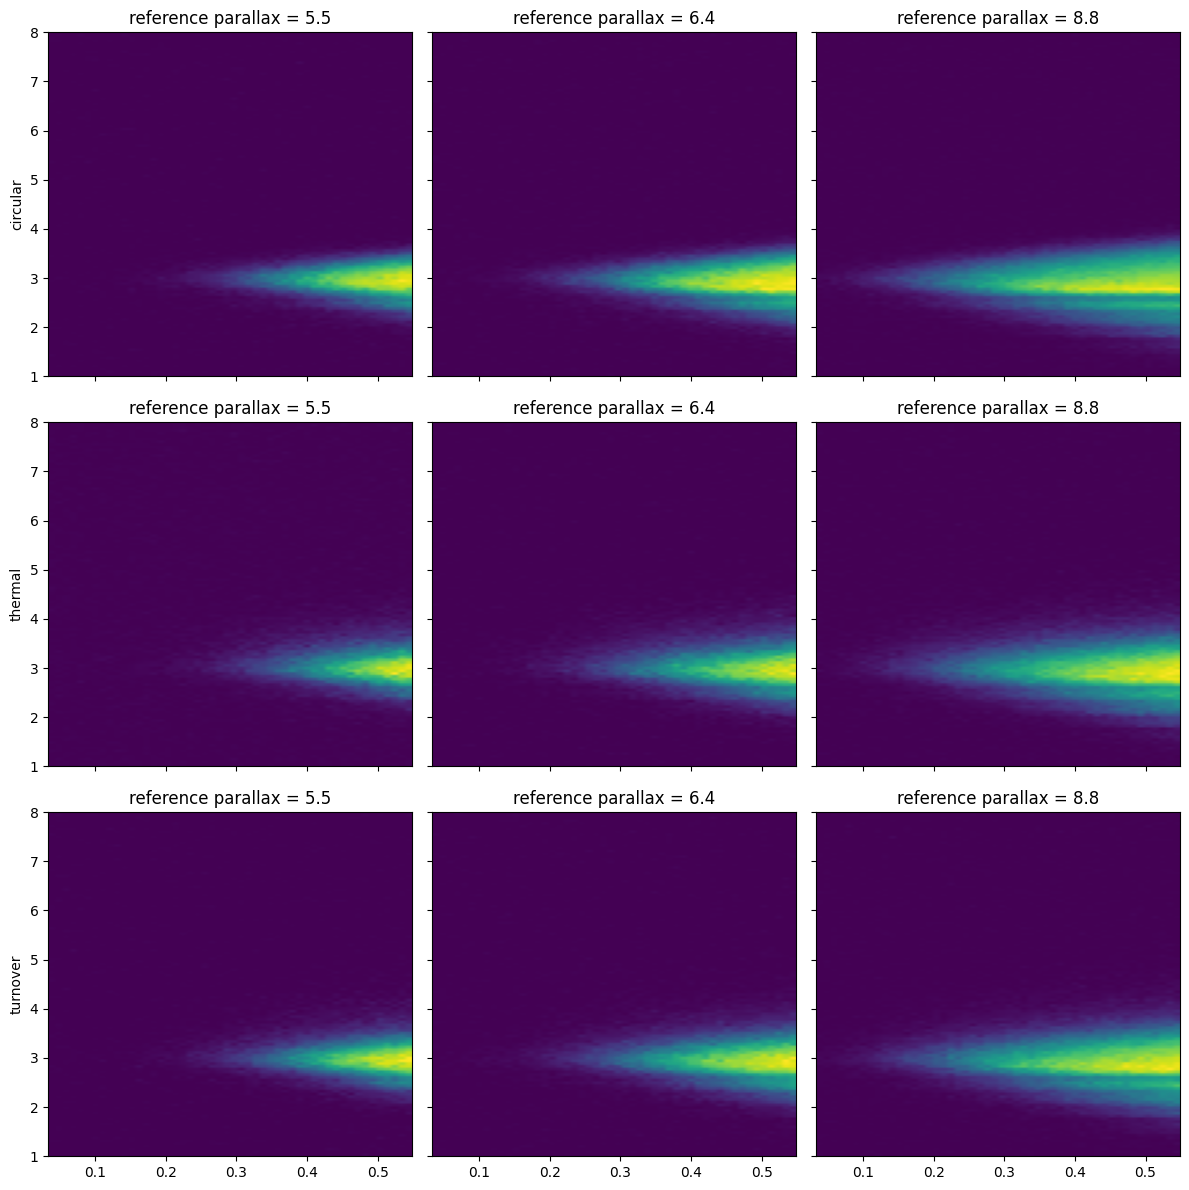

In [7]:
fig, axs = plt.subplots(3,3, figsize=(12,12), sharex=True, sharey=True)

for i in range(3):
    for j, cubes in enumerate([imported_cube_circular, imported_cube_thermal, imported_cube_turnover]):
        ax = axs[j,i]
        if i == 0:
            ax.set_ylabel(["circular", "thermal", "turnover"][j])
        logps = np.log10(cubes["meta"]["periods"])
        yrange = (logps[-1], logps[0])
        plxs = list(cubes["cube"].keys())
        lams = cubes["meta"]["qs"][i]
        xrange = np.array((lams[0], lams[-1]))
        extent = [*xrange, *yrange]
        extent = [float(e) for e in extent]
        ax.imshow(np.mean(cubes["cube"][plxs[i]], axis=2), extent=extent, aspect="auto")
        ax.set_title("reference parallax = {:.1f}".format(plxs[i]))
        ax.invert_yaxis()
    
plt.tight_layout()

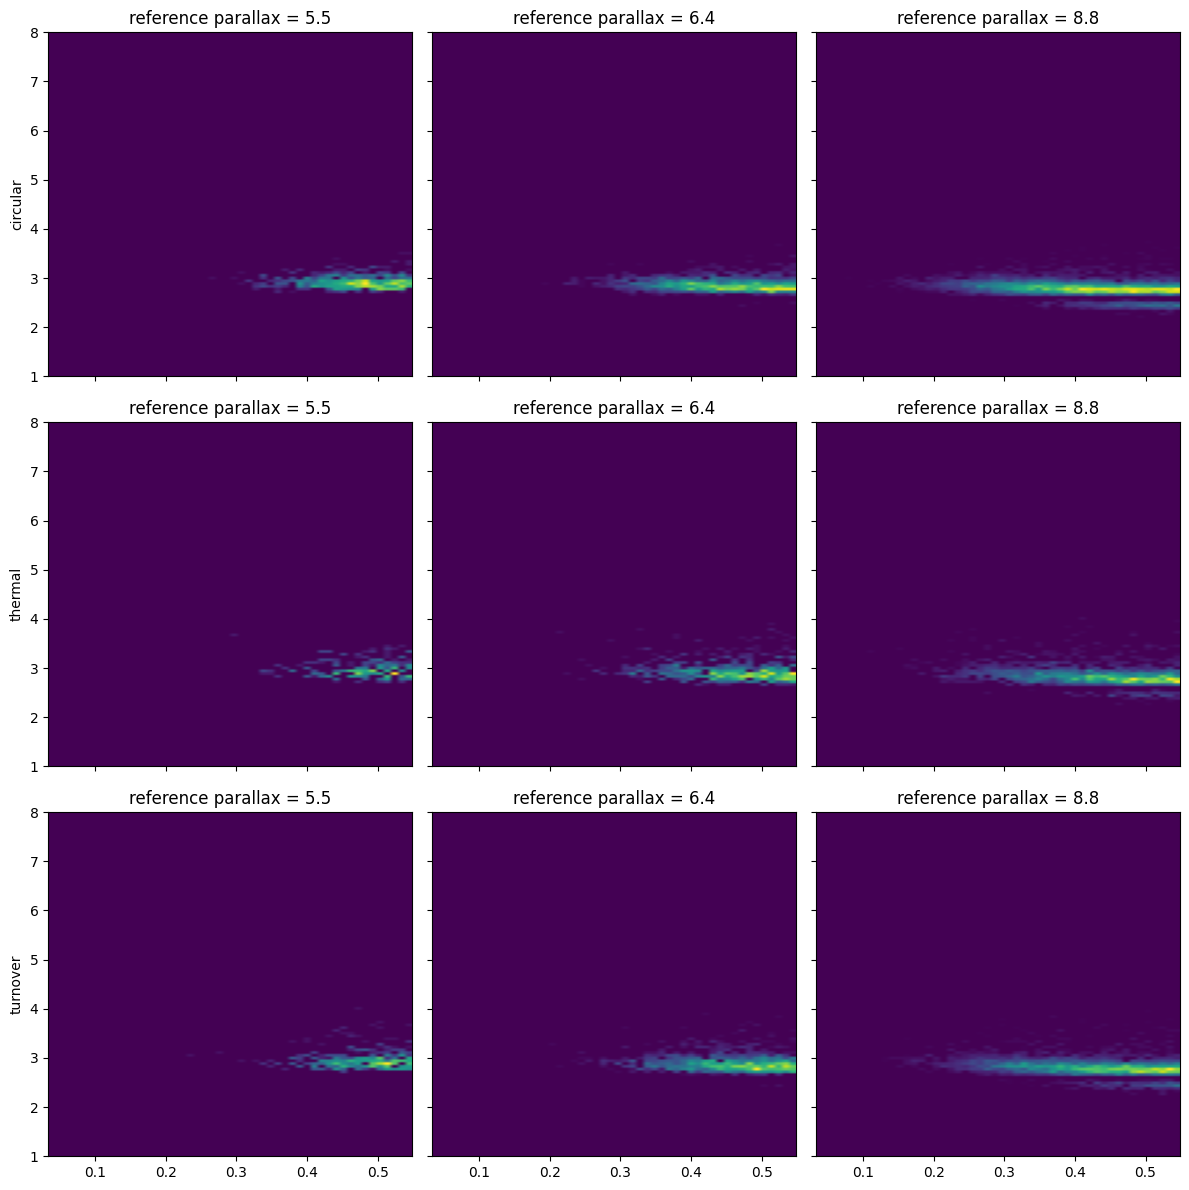

In [15]:
fig, axs = plt.subplots(3,3, figsize=(12,12), sharex=True, sharey=True)

soldex = 4
for i in range(3):
    for j, cubes in enumerate([imported_cube_circular, imported_cube_thermal, imported_cube_turnover]):
        ax = axs[j,i]
        if i == 0:
            ax.set_ylabel(["circular", "thermal", "turnover"][j])
        logps = np.log10(cubes["meta"]["periods"])
        yrange = (logps[-1], logps[0])
        plxs = list(cubes["cube"].keys())
        lams = cubes["meta"]["qs"][i]
        xrange = np.array((lams[0], lams[-1]))
        extent = [*xrange, *yrange]
        extent = [float(e) for e in extent]
        ax.imshow(cubes["data"][plxs[i]][:,:,soldex], extent=extent, aspect="auto")
        ax.set_title("reference parallax = {:.1f}".format(plxs[i]))
        ax.invert_yaxis()
    
plt.tight_layout()

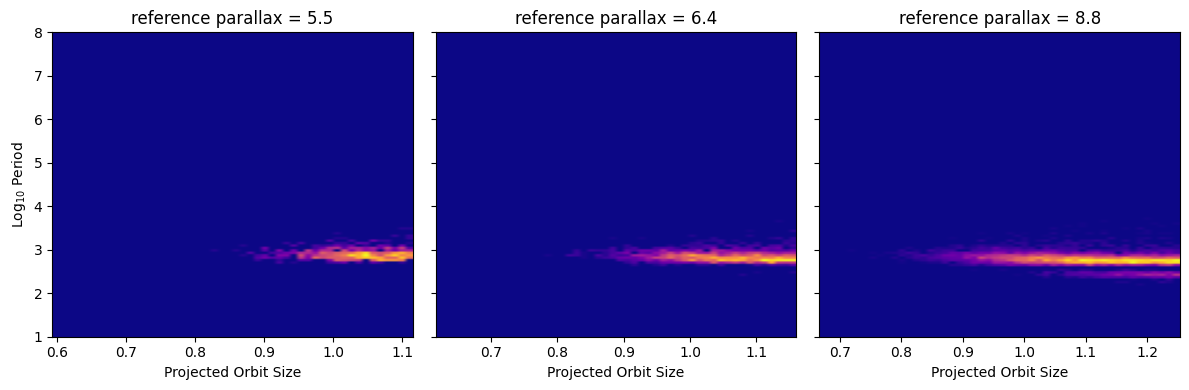

In [26]:
soldex = 4
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True);
axs[0].set_ylabel(r"$\text{Log}_{10}$ Period");
for i, ax in enumerate(axs):
    lams = imported_cube["meta"]["lambdas"][i]**(1/4)
    xrange = np.array((lams[0], lams[-1]))
    logps = np.log10(imported_cube["meta"]["periods"])
    yrange = (logps[-1], logps[0])
    extent = [*xrange, *yrange]
    extent = [float(e) for e in extent]

    ax.imshow(imported_cube["data"][plxs[i]][:,:,soldex], extent=extent, aspect="auto", cmap="plasma");
    ax.invert_yaxis()
    ax.set_xlabel("Projected Orbit Size");
    ax.set_title("reference parallax = {:.1f}".format(plxs[i]))
fig.tight_layout()

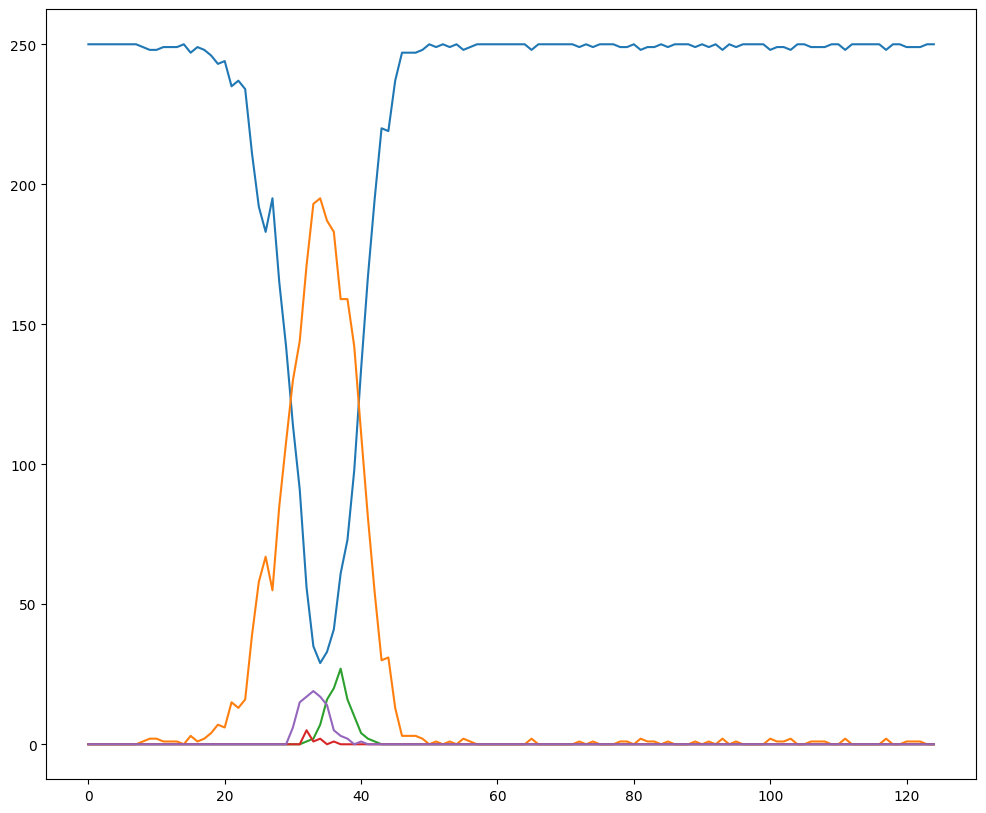

In [16]:
plt.plot(imported_cube["data"][plxs[0]][:,40,:]);